# Preprocessing

In [1]:
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt

In [2]:
clinical_data_df = pd.read_excel(
    '../data/raw/CMMD/CMMD_clinicaldata_revision.xlsx')
metadata_df = pd.read_csv('../data/raw/CMMD/metadata.csv')

In [3]:
metadata_df[metadata_df['Data Description URI'] == 'D2-0749'].iloc[0]['File Location']

'./CMMD/D2-0749/07-17-2012-NA-NA-85032/1.000000-NA-15082'

In [4]:
data_df = clinical_data_df[clinical_data_df['subtype'].notnull()]

In [5]:
data_df.shape

(749, 7)

In [6]:
# Merge dataframes
data_df = data_df.merge(metadata_df, left_on='ID1', right_on='Data Description URI')

In [7]:
data_df = data_df[['ID1', 'LeftRight', 'Age', 'abnormality', 'subtype', 'File Location']]

In [8]:
data_df.head()

,ID1,LeftRight,Age,abnormality,subtype,File Location
0,D2-0001,L,64,calcification,Luminal B,./CMMD/D2-0001/07-18-2011-NA-NA-75485/1.000000...
1,D2-0002,R,69,calcification,Luminal B,./CMMD/D2-0002/07-18-2010-NA-NA-26354/1.000000...
2,D2-0003,L,44,calcification,Luminal B,./CMMD/D2-0003/07-18-2010-NA-NA-57046/1.000000...
3,D2-0004,L,38,calcification,Luminal B,./CMMD/D2-0004/07-18-2010-NA-NA-29234/1.000000...
4,D2-0005,R,41,calcification,HER2-enriched,./CMMD/D2-0005/07-18-2010-NA-NA-26051/1.000000...


In [9]:
data_df.rename(columns={'ID1': 'patientId', 'LeftRight': 'malignantSide', 'Age': 'age', 'File Location': 'originalPath'}, inplace=True)

In [10]:
data_df['subtype'].value_counts()

subtype
Luminal B          376
Luminal A          152
HER2-enriched      135
triple negative     86
Name: count, dtype: int64

In [11]:
data_df['subtype'] = data_df['subtype'].map({'Luminal B': 'luminal-b', 'Luminal A': 'luminal-a', 'HER2-enriched': 'her2-enriched', 'triple negative': 'triple-negative'})

In [12]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,./CMMD/D2-0001/07-18-2011-NA-NA-75485/1.000000...
1,D2-0002,R,69,calcification,luminal-b,./CMMD/D2-0002/07-18-2010-NA-NA-26354/1.000000...
2,D2-0003,L,44,calcification,luminal-b,./CMMD/D2-0003/07-18-2010-NA-NA-57046/1.000000...
3,D2-0004,L,38,calcification,luminal-b,./CMMD/D2-0004/07-18-2010-NA-NA-29234/1.000000...
4,D2-0005,R,41,calcification,her2-enriched,./CMMD/D2-0005/07-18-2010-NA-NA-26051/1.000000...


In [13]:
data_df['originalPath'] = data_df['originalPath'].str.replace('./CMMD/', 'images/')

In [14]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,images/D2-0001/07-18-2011-NA-NA-75485/1.000000...
1,D2-0002,R,69,calcification,luminal-b,images/D2-0002/07-18-2010-NA-NA-26354/1.000000...
2,D2-0003,L,44,calcification,luminal-b,images/D2-0003/07-18-2010-NA-NA-57046/1.000000...
3,D2-0004,L,38,calcification,luminal-b,images/D2-0004/07-18-2010-NA-NA-29234/1.000000...
4,D2-0005,R,41,calcification,her2-enriched,images/D2-0005/07-18-2010-NA-NA-26051/1.000000...


In [15]:
data_df['originalPath'] = data_df['originalPath'].str.replace('images/', '../data/raw/CMMD/images/')

In [16]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...
1,D2-0002,R,69,calcification,luminal-b,../data/raw/CMMD/images/D2-0002/07-18-2010-NA-...
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...
4,D2-0005,R,41,calcification,her2-enriched,../data/raw/CMMD/images/D2-0005/07-18-2010-NA-...


In [17]:
data_df_11 = data_df.copy()
data_df_11['originalPath'] = data_df_11['originalPath'] + '/1-1.dcm'
data_df_11 = data_df_11[data_df_11['originalPath'].apply(os.path.exists)]
data_df_11['view'] = 'CC'

data_df_12 = data_df.copy()
data_df_12['originalPath'] = data_df_12['originalPath'] + '/1-2.dcm'
data_df_12 = data_df_12[data_df_12['originalPath'].apply(os.path.exists)]
data_df_12['view'] = 'MLO'

data_df_13 = data_df.copy()
data_df_13['originalPath'] = data_df_13['originalPath'] + '/1-3.dcm'
data_df_13 = data_df_13[data_df_13['originalPath'].apply(os.path.exists)]
data_df_13['view'] = 'CC'

data_df_14 = data_df.copy()
data_df_14['originalPath'] = data_df_14['originalPath'] + '/1-4.dcm'
data_df_14 = data_df_14[data_df_14['originalPath'].apply(os.path.exists)]
data_df_14['view'] = 'MLO'

cmmd = pd.concat([data_df_11, data_df_12, data_df_13, data_df_14])

In [18]:
cmmd.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...,CC
1,D2-0002,R,69,calcification,luminal-b,../data/raw/CMMD/images/D2-0002/07-18-2010-NA-...,CC
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...,CC
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...,CC
4,D2-0005,R,41,calcification,her2-enriched,../data/raw/CMMD/images/D2-0005/07-18-2010-NA-...,CC


In [19]:
# Fix laterality and view
for i, row in cmmd.iterrows():
    if '1-3.dcm' in row['originalPath']:
        patientID = row['patientId']
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-1.dcm')), 'laterality'] = 'L'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-2.dcm')), 'laterality'] = 'L'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-1.dcm')), 'view'] = 'CC'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-2.dcm')), 'view'] = 'MLO'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-3.dcm')), 'laterality'] = 'R'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-3.dcm')), 'view'] = 'CC'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-4.dcm')), 'laterality'] = 'R'
        cmmd.loc[(cmmd['patientId'] == patientID) & (
            cmmd['originalPath'].str.contains('1-4.dcm')), 'view'] = 'MLO'

In [20]:
cmmd['laterality'] = cmmd['laterality'].fillna(cmmd['malignantSide'])

In [21]:
cmmd.shape

(2988, 8)

In [22]:
cmmd_filtered = cmmd[cmmd['laterality'] == cmmd['malignantSide']]
cmmd_filtered.shape

(1498, 8)

In [23]:
cmmd_filtered.query('patientId == "D2-0402"')

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
401,D2-0402,R,49,mass,luminal-a,../data/raw/CMMD/images/D2-0402/07-18-2010-NA-...,CC,R
401,D2-0402,R,49,mass,luminal-a,../data/raw/CMMD/images/D2-0402/07-18-2010-NA-...,MLO,R


In [24]:
patient = cmmd_filtered.query('patientId == "D2-0026"')
patient

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
25,D2-0026,L,46,calcification,luminal-b,../data/raw/CMMD/images/D2-0026/07-18-2010-NA-...,CC,L
25,D2-0026,L,46,calcification,luminal-b,../data/raw/CMMD/images/D2-0026/07-18-2010-NA-...,MLO,L


In [25]:
dcm = pydicom.dcmread(patient.iloc[0]['originalPath'])
dcm.ImageLaterality

'L'

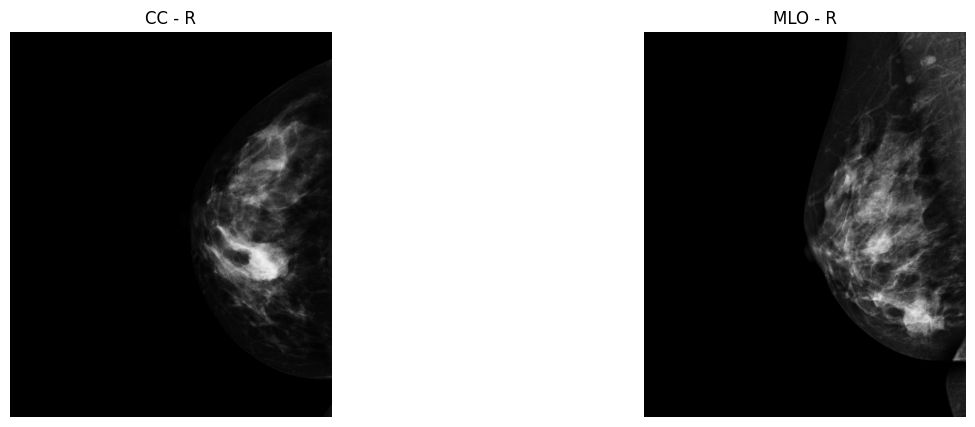

In [26]:
first_patient = cmmd_filtered.query('patientId == "D2-0402"')
# subplot for each view
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
index = 0
for i, row in first_patient.iterrows():
    dcm = pydicom.dcmread(row['originalPath'])

    axs[index].imshow(dcm.pixel_array, cmap='gray')
    axs[index].set_title(f'{row["view"]} - {row["laterality"]}')
    axs[index].axis('off')
    index += 1
plt.show()

In [27]:
cmmd_converted = cmmd_filtered.copy()
cmmd_converted['convertedPath'] = ''

In [33]:
import cv2
import numpy as np
import os
import shutil
from src.preprocessing import crop_image_roi, apply_clahe

output_folder = '../data/processed/converted/'

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

index = 0
for i, row in cmmd_converted.iterrows():
    dcm = pydicom.dcmread(row['originalPath'])
    img = dcm.pixel_array
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.uint8(img)
    cropped_img = crop_image_roi(img)
    processed_img = apply_clahe(cropped_img)
    patient_folder = os.path.join(output_folder, row['patientId'])
    os.makedirs(patient_folder, exist_ok=True)
    image_name = f'{row["view"]}-{row["malignantSide"]}.png'
    cmmd_converted.iloc[index, cmmd_converted.columns.get_loc('convertedPath')] = os.path.join(patient_folder, image_name)
    cv2.imwrite(os.path.join(patient_folder, image_name), processed_img)
    index += 1

In [29]:
cmmd_filtered.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...,CC,L
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...,CC,L
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...,CC,L
11,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/images/D2-0012/07-18-2010-NA-...,CC,L
12,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/images/D2-0013/07-18-2010-NA-...,CC,L


In [30]:
cmmd_converted.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality,convertedPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/images/D2-0001/07-18-2011-NA-...,CC,L,../data/processed/converted/D2-0001/CC-L.png
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/images/D2-0003/07-18-2010-NA-...,CC,L,../data/processed/converted/D2-0003/CC-L.png
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/images/D2-0004/07-18-2010-NA-...,CC,L,../data/processed/converted/D2-0004/CC-L.png
11,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/images/D2-0012/07-18-2010-NA-...,CC,L,../data/processed/converted/D2-0012/CC-L.png
12,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/images/D2-0013/07-18-2010-NA-...,CC,L,../data/processed/converted/D2-0013/CC-L.png


In [31]:
cmmd_converted.to_csv('../data/processed/cmmd_converted.csv', index=False)